In [1]:
%matplotlib inline

import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rawData = pd.read_json('../HourDataSetRaw/archive/SILVER.json','index')

In [3]:
dataSlice = 600
rawData.dropna(inplace=True)
rawData['dateTimeStr'] = rawData['dateStr'] + ' ' + rawData['timeStr']
rawData['dateTime'] = pd.to_datetime(rawData['dateTimeStr'], format='%Y-%m-%d %H:%M')
rawData.sort_values('dateTime', inplace=True)
rawData.set_index('dateTime', inplace=True)
df = rawData.iloc[rawData.shape[0]-dataSlice:rawData.shape[0], 0:rawData.shape[1]]
print(df.shape)
df.head()

(600, 9)


,time,open,high,low,close,date,timeStr,dateStr,dateTimeStr
dateTime,,,,,,,,,
2020-01-06 07:00:00,1.578326e+12,18.091,18.103,18.071,18.092,2020-01-05 21:00:00,07:00,2020-01-06,2020-01-06 07:00
2020-01-06 08:00:00,1.578330e+12,18.093,18.166,18.086,18.150,2020-01-05 21:00:00,08:00,2020-01-06,2020-01-06 08:00
2020-01-06 08:00:00,1.578287e+12,18.400,18.438,18.368,18.372,2020-01-05 21:00:00,08:00,2020-01-06,2020-01-06 08:00
2020-01-06 09:00:00,1.578290e+12,18.373,18.376,18.312,18.338,2020-01-05 21:00:00,09:00,2020-01-06,2020-01-06 09:00
2020-01-06 09:00:00,1.578334e+12,18.153,18.163,18.101,18.116,2020-01-05 21:00:00,09:00,2020-01-06,2020-01-06 09:00


In [26]:
df['close_ret'] = np.log(df['close']).diff()

In [96]:
df.head()

,open,high,low,close,date,timeStr,dateStr,close_ret
time,,,,,,,,
1.578312e+12,18.410,18.446,18.314,18.348,2020-01-05 21:00:00,03:00,2020-01-06,NaN
1.578316e+12,18.349,18.383,18.282,18.286,2020-01-05 21:00:00,04:00,2020-01-06,-0.003385
1.578319e+12,18.287,18.318,18.000,18.069,2020-01-05 21:00:00,05:00,2020-01-06,-0.011938
1.578323e+12,18.070,18.106,18.047,18.092,2020-01-05 21:00:00,06:00,2020-01-06,0.001272
1.578326e+12,18.091,18.103,18.071,18.092,2020-01-05 21:00:00,07:00,2020-01-06,0.000000


In [97]:
df.dropna(inplace=True)

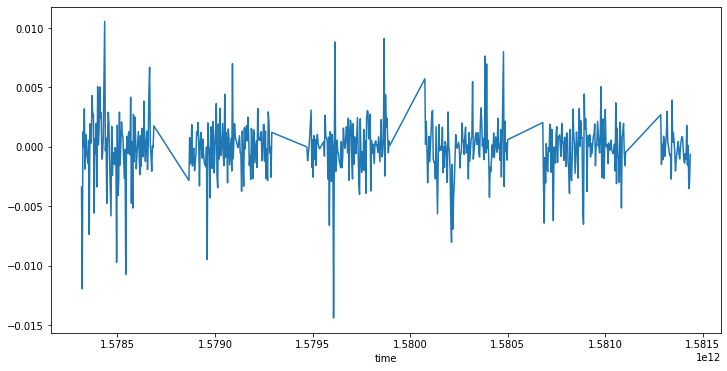

In [98]:
df.close_ret.plot(kind='line', figsize=(12, 6))

In [99]:
udiff = df.drop(['open', 'close', 'high', 'low', 'date', 'timeStr', 'dateStr'], axis=1)
udiff.head()

,close_ret
time,
1.578316e+12,-0.003385
1.578319e+12,-0.011938
1.578323e+12,0.001272
1.578326e+12,0.000000
1.578330e+12,0.003201


In [100]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [101]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

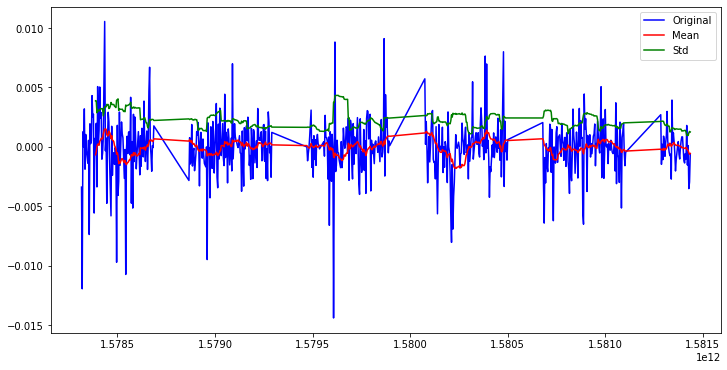

In [102]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Mean')
std = plt.plot(rolstd, color='green', label='Std')
plt.legend(loc='best')
plt.show(block=False)

In [103]:
# perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.close_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test statistic', 'p-value', '#Lags used', 'Number of observation used'])
for key, value in dftest[4].items():
    dfoutput['Critical value ({0})'.format(key)] = value
    
dfoutput

Test statistic                -24.644212
p-value                         0.000000
#Lags used                      0.000000
Number of observation used    597.000000
Critical value (1%)            -3.441351
Critical value (5%)            -2.866393
Critical value (10%)           -2.569355
dtype: float64

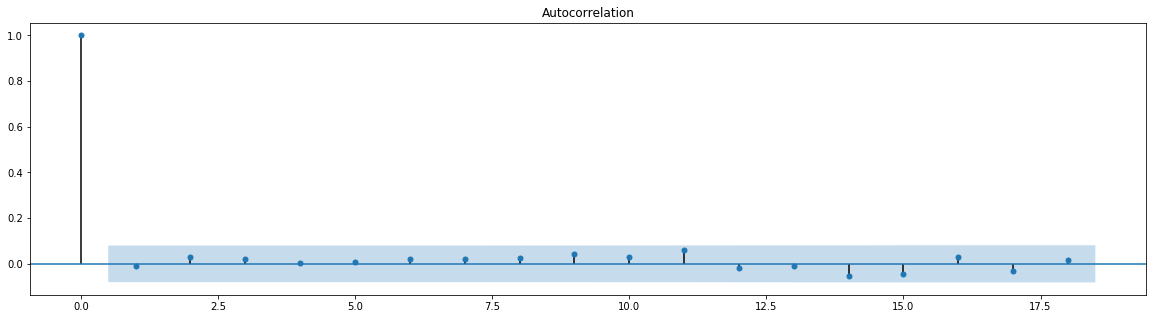

In [104]:
#Autocorelation chart
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(udiff.values, lags=18, ax=ax)
plt.show()

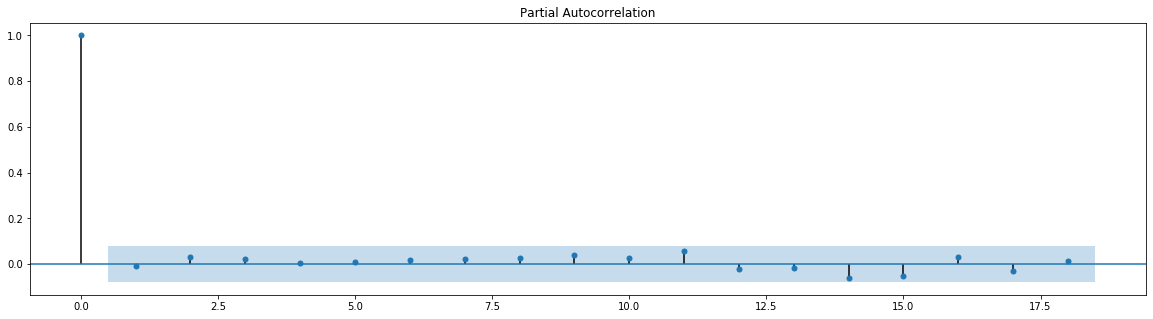

In [105]:
#Partial autocorelation chart
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(udiff.values, lags=18, ax=ax)
plt.show()

In [106]:
#Arima model
import statsmodels.tsa.arima_model as ARMA

ar1 = ARMA.ARMA(tuple(udiff.values), (11, 11)).fit()
ar1.summary()

/Users/anton/Documents/Develop/Projects/AI/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/anton/Documents/Develop/Projects/AI/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/anton/Documents/Develop/Projects/AI/venv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/anton/Documents/Develop/Projects/AI/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/anton/Documents/Develop/Projects/AI/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  598
Model:                   ARMA(11, 11)   Log Likelihood                2764.342
Method:                       css-mle   S.D. of innovations              0.002
Date:                Wed, 12 Feb 2020   AIC                          -5480.684
Time:                        22:24:59   BIC                          -5375.238
Sample:                             0   HQIC                         -5439.630
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.282e-05      0.000     -0.684      0.494      -0.000       0.000
ar.L1.y        0.0541      0.493      0.110      0.913      -0.913       1.021
ar.L2.y       -0.0706      0.218     -0.324      0.746      -0.497       0.356
ar.L3.y       -0.2418        nan        nan        nan         nan         nan
ar.L4.y       -0.2350        nan        nan        nan         nan         nan
ar.L5.y        0.0494      0.177      0.279      0.781      -0.298       0.397
ar.L6.y       -0.4420      0.102     -4.316      0.000      -0.643      -0.241
ar.L7.y       -0.0019      0.221     -0.009      0.993      -0.436       0.432
ar.L8.y       -0.0244      0.233     -0.104      0.917      -0.482       0.433
ar.L9.y        0.0605      0.198      0.305      0.760      -0.328       0.449
ar.L10.y      -0.2426        nan        nan        nan         nan         nan
ar.L11.y       0.5222      0.238      2.193      0.028       0.055       0.989
ma.L1.y       -0.0632      0.500     -0.126      0.899      -1.043       0.917
ma.L2.y        0.0905      0.229      0.395      0.693      -0.358       0.539
ma.L3.y        0.2522        nan        nan        nan         nan         nan
ma.L4.y        0.2617        nan        nan        nan         nan         nan
ma.L5.y       -0.0231      0.179     -0.129      0.897      -0.374       0.328
ma.L6.y        0.4875      0.072      6.798      0.000       0.347       0.628
ma.L7.y        0.0120      0.255      0.047      0.962      -0.489       0.513
ma.L8.y        0.0978      0.237      0.414      0.679      -0.366       0.562
ma.L9.y       -0.0170      0.142     -0.120      0.904      -0.295       0.261
ma.L10.y       0.3019        nan        nan        nan         nan         nan
ma.L11.y      -0.4405      0.225     -1.955      0.051      -0.882       0.001
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -0.9473           -0.3544j            1.0115           -0.4430
AR.2            -0.9473           +0.3544j            1.0115            0.4430
AR.3            -0.7149           -0.7859j            1.0624           -0.3675
AR.4            -0.7149           +0.7859j            1.0624            0.3675
AR.5            -0.0489           -1.0458j            1.0469           -0.2574
AR.6            -0.0489           +1.0458j            1.0469            0.2574
AR.7             0.4898           -0.9773j            1.0932           -0.1761
AR.8             0.4898           +0.9773j            1.0932            0.1761
AR.9             0.8386           -0.5712j            1.0146           -0.0952
AR.10            0.8386           +0.5712j            1.0146            0.0952
AR.11            1.2299           -0.0000j            1.2299           -0.0000
MA

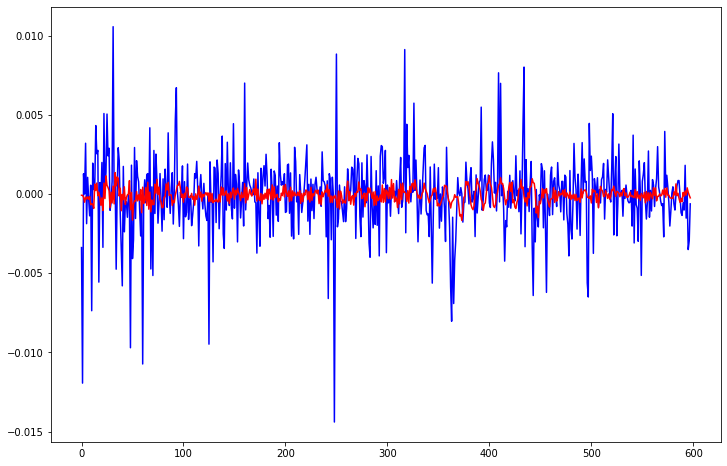

In [107]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

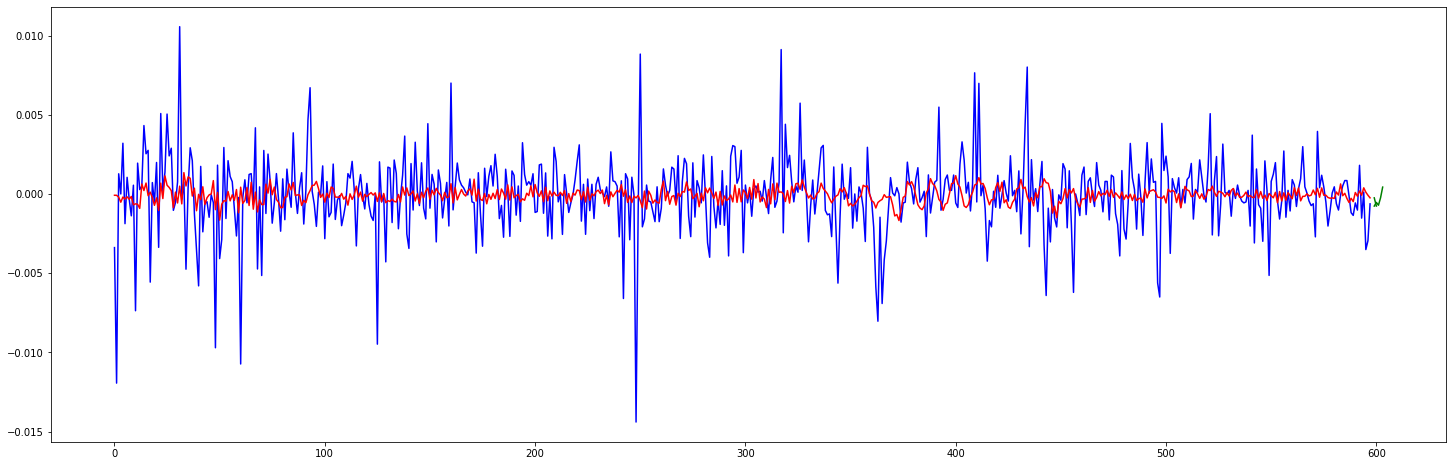

In [108]:
# Forecast
steps = 5

forecast = ar1.forecast(steps=steps)[0]

plt.figure(figsize=(25, 8))
plt.plot(udiff.values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1], forecast[0]]).T, index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast, index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.show()